In [60]:
import os
import autogen
import autogen.runtime_logging
import pandas as pd
import sqlite3
import json
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
from preprocessing.preprocessing import generate_conversations,process_pdf,rubric_processor
from multi_agent import subjective_agent,objective_agent,assessment_plan_agent
from general_SOAP_Note_agent import single_agent_generation,soapnoteagent
from evaluation_agent import evaluator_agent,score_generation,detail_score_generation
from refiner_agent import refiner_agent,refine_generation

In [61]:
conversation_list,conversation_names=generate_conversations('C:/Users/rahul/Desktop/SOAPNote/dataset/VAT Patient Transcripts/VAT Patient Transcripts/')
MA_conversation_list=[i for i in conversation_list if ' M.A. User' in i]
RT_conversation_list=[i for i in conversation_list if 'R.T. User' in i or 'Patient R.T.’s Alexa' in i] 
RT_conversation_list=[i for i in RT_conversation_list if 'Baseline' not in i and 'Debrief' not in i  ]
rubric=rubric_processor('C:/Users/rahul/Desktop/SOAPNote/rubric/rubric.docx')
s_rubric=rubric.split('\nSubjective\n')[1].split('\nObjective\n')[0]
o_rubric=rubric.split('\nObjective\n')[1].split('\nAssessment\n')[0]
ap_rubric=rubric.split('\nAssessment\n')[1].split('\nIssues of Concern\n')[0]

In [62]:
from pypdf import PdfReader
MA_SOAP_NOTES_LIST_1=[]
path='C:/Users/rahul/Desktop/SOAPNote/dataset/ground_truth_soap_notes/MA'

for i in os.listdir('C:/Users/rahul/Desktop/SOAPNote/dataset/ground_truth_soap_notes/MA'):
    soap_note_ma=""
    file_name=path+'/'+i
    reader=PdfReader(file_name)
    if 'Week_1' not in file_name:
        for j in range(0,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            soap_note_ma+=text
    else:
        for j in range(1,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            soap_note_ma+=text
    MA_SOAP_NOTES_LIST_1.append(soap_note_ma)

RT_SOAP_NOTES_LIST_1=[]
file_name="C:/Users/rahul/Desktop/SOAPNote/dataset/ground_truth_soap_notes/RT/Clinician - RT SOAP Notes.pdf"
reader=PdfReader(file_name)
for i in range(0,len(reader.pages)):
    soap_note_ra=""
    page=reader.pages[i]
    text=page.extract_text()
    text=text.replace('\n','')
    soap_note_ra+=text
    RT_SOAP_NOTES_LIST_1.append(soap_note_ra)
RT_SOAP_NOTES_LIST_1=RT_SOAP_NOTES_LIST_1[:4]

In [63]:
MA_path="C:/Users/rahul/Desktop/SOAPNote/dataset/Cohort 4 Training (RT & MA) Summer 2025/MA"
RT_path="C:/Users/rahul/Desktop/SOAPNote/dataset/Cohort 4 Training (RT & MA) Summer 2025/RT"
MA_conversation_list_2=[]
RT_conversation_list_2=[]
RT_SOAP_NOTES_2=""
MA_SOAP_NOTES_2=""
session2_file_name="C:/Users/rahul/Desktop/SOAPNote/dataset/Cohort 4 Training (RT & MA) Summer 2025/MA/Session 2 Transcript_ M.A. (7-10-2025).pdf"
reader=PdfReader(session2_file_name)
transcript=""
for j in range(0,len(reader.pages)):
    page=reader.pages[j]
    text=page.extract_text()
    text=text.replace('\n','')
    transcript+=text
MA_conversation_list_2.append(transcript)
for i in os.listdir(MA_path):
    if 'pdf' in i and 'SOAP Notes' not in i:
        transcript_ma=""
        file_name=MA_path+'/'+i
        reader=PdfReader(file_name)
        for j in range(0,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            transcript_ma+=text
        MA_conversation_list_2.append(transcript_ma)
    elif 'pdf' in i and 'SOAP Notes' in i:
        file_name=MA_path+'/'+i
        reader=PdfReader(file_name)
        for j in range(0,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            MA_SOAP_NOTES_2+=text


for i in os.listdir(RT_path):
    if 'pdf' in i and 'SOAP Notes' not in i:
        transcript_ma=""
        file_name=RT_path+'/'+i
        reader=PdfReader(file_name)
        for j in range(0,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            transcript_ma+=text
        RT_conversation_list_2.append(transcript_ma)

file_name="C:/Users/rahul/Desktop/SOAPNote/dataset/Cohort 4 Training (RT & MA) Summer 2025/RT/R.T. SOAP Note (Cohor 4 2025).pdf"
reader=PdfReader(file_name)
for j in range(0,len(reader.pages)):
    page=reader.pages[j]
    text=page.extract_text()
    text=text.replace('\n','')
    RT_SOAP_NOTES_2+=text

MA_SOAP_NOTE_LIST_2=[MA_SOAP_NOTES_2.split('Session 2')[1].split('Session 3')[0],MA_SOAP_NOTES_2.split('Session 4')[1].split('Session 5')[0],MA_SOAP_NOTES_2.split('Session 6')[1]]
RT_SOAP_NOTE_LIST_2=[RT_SOAP_NOTES_2.split('Session 1')[1].split('Session 2')[0],
RT_SOAP_NOTES_2.split('Session 2')[1].split('Session 3')[0],
RT_SOAP_NOTES_2.split('Session 3')[1].split('Session 4')[0],
RT_SOAP_NOTES_2.split('Session 4')[1].split('Session 5')[0],
RT_SOAP_NOTES_2.split('Session 5')[1].split('Session 6')[0],
RT_SOAP_NOTES_2.split('Session 6')[1].split('Session 1')[0]]
RT_SOAP_NOTE_LIST_2=RT_SOAP_NOTE_LIST_2[1:]
MA_conversation_list_2_1=MA_conversation_list_2[2:]
MA_conversation_list_2_1[2]=MA_conversation_list_2_1[2]+"\n"+MA_conversation_list_2_1[3]
MA_conversation_list_2_final=MA_conversation_list_2_1[0:3]
    

In [64]:
MA_TRANSCRIPTS=MA_conversation_list+MA_conversation_list_2_final
RT_TRANSCRIPTS=RT_conversation_list+RT_conversation_list_2
RT_TRANSCRIPTS_FINAL=RT_TRANSCRIPTS[0:4]+RT_TRANSCRIPTS[8:13]
MA_SOAP_NOTES=MA_SOAP_NOTES_LIST_1+MA_SOAP_NOTE_LIST_2
RT_SOAP_NOTES=RT_SOAP_NOTES_LIST_1+RT_SOAP_NOTE_LIST_2

In [65]:
len(MA_TRANSCRIPTS)

8

In [66]:
len(RT_TRANSCRIPTS_FINAL)

9

In [67]:
from sklearn.model_selection import train_test_split
training_dict=dict()
for i in range(0,len(MA_TRANSCRIPTS)):
    training_dict[MA_TRANSCRIPTS[i]]=MA_SOAP_NOTES[i]

for i in range(0,len(RT_TRANSCRIPTS_FINAL)):
    training_dict[RT_TRANSCRIPTS_FINAL[i]]=RT_SOAP_NOTES[i]

X=list(training_dict.keys())
y=list(training_dict.values())
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42)

In [68]:
X_train

["WEBVTT  1 00:00:00.000 --> 00:00:08.710 Claire O'Connor: So, R, with your, oh, okay, awesome. I was just gonna hit record. Okay, so I'm gonna share my screen and let me go back. So it looks a little different compared to last time we made the format a little more accessible. So we're going to be working on entertainment similar to what we worked on for. The voice commands for Alexa. Entertainment can be used for things like telling a joke, listening to music or watching movies. Unlike the skills that Alexa had where we use them to look up. Movie trailers look up specific songs and tell us a joke. We now have gemini which can search for information and media. It could also create content. So with enough tokens, you could create images using gemini and then also generating interactive stories. So, for example, if you want to rehearse a conversation that you feel a little nervous about, this is the perfect opportunity to do so, and then also. Gemini has the capability of telling jokes a

In [69]:
import textgrad as tg
import textgrad as tg
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
import os
config_list = config_list_from_json("C:/Users/rahul/Documents/OAI_CONFIG_LIST.json")
api_key=config_list[0]['api_key']
os.environ["OPENAI_API_KEY"] = api_key
os.environ["OLLAMA_API_BASE"] = "http://localhost:11434"
model_name = "ollama_chat/deepseek-r1"
llm_engine = tg.get_engine("gpt-4o")
tg.set_backward_engine("gpt-4o",override=True)

def batch_eval_fn(prediction,ground_truth):
    totalloss=None
    cross_entropy_loss_list=[]
    for pred,ans in zip(prediction,ground_truth):
        eval_system_prompt= f"""How closely does the generated SOAP note match this target SOAP note? Return a higher loss score for greater differences.

TARGET: {ans.value}

Score from 0-10 where:
- 0 = Perfect match
- 10 = Completely different"""
        cross_entropy_loss=tg.TextLoss(eval_system_prompt=eval_system_prompt,engine=llm_engine)
        cross_entropy_loss_list.append(cross_entropy_loss(pred))
    totalloss=tg.sum(cross_entropy_loss_list)
    return totalloss

question_str_list=[]
for i in X_train:
    question_str=f'''What would a comprehensive SOAP note look like based strictly on the 
    following conversation between a patient and a clinician: {i}, 
    ensuring it includes all relevant details from the conversation and follows the structure and style described in the provided rubric : {rubric}? '''
    question_str_list.append(tg.Variable(question_str,role_description="question to the LLM", requires_grad=False))
answer=[tg.Variable(i,role_description="answer to the question",requires_grad=False) for i in y_train]

system_prompt = tg.Variable(f"You are a clinician who is responsible for generating a SOAP Note from the conversation between the doctor(s) and the patient.  Include all relevant details in the desired format.",
                            requires_grad=True,
                            role_description="system prompt to guide the LLM's reasoning strategy for accurate responses")


model = tg.BlackboxLLM(llm_engine, system_prompt=system_prompt)
optimizer = tg.TGD(parameters=list(model.parameters()))
prediction_list=[model(i) for i in question_str_list]
loss = batch_eval_fn(prediction_list,answer)
loss.backward()
optimizer.step()

KeyboardInterrupt: 

In [ ]:
qwen_prompt='''You are a clinician responsible for generating a SOAP note for a patient, but you must first determine the context of the patient's role. If the patient is an AI model (e.g., Gemini, Alexa, or another AI tool), focus on their interaction with users, task completion, and independence in using the tool. If the patient is a human, proceed with the standard SOAP structure. Always include the following elements in your response:

1. **Context Clarification:**  
   - If the patient is an AI (e.g., Rosie using Gemini/Alexa), explicitly state this in the note.  
   - If the patient is a human, confirm the medical context (e.g., TBI, cognitive deficits).

2. **Structure Alignment:**  
   - Use bullet points or clear sections (e.g., **S**, **O**, **A**, **P**) for readability.  
   - Include **quantifiable metrics** (e.g., "Rosie independently formulated 5/6 prompts for Gemini" or "required 2 cues to access Gemini").

3. **Target-Specific Focus:**  
   - If the patient is an AI, emphasize **user interaction** (e.g., "Rosie demonstrated 80% accuracy in Gemini prompt formulation"), **task completion** (e.g., "Independently created 3 prompts for surfing"), and **independence** (e.g., "Minimal cues required for task execution").  
   - If the patient is a human, prioritize **cognitive, speech, and physical deficits** (e.g., "Left eye tracking: Poor; no visual acuity abnormalities").

4. **Avoid Confusion:**  
   - Do not assume a human patient unless explicitly stated.  
   - If the prompt is ambiguous (e.g., "Rosie"), prioritize the AI context unless instructed otherwise.

5. **Example Format:**  
   - **S:** [Time spent on task, user interaction]  
   - **O:** [Quantifiable observations, AI tool usage metrics]  
   - **A:** [Diagnosis, AI-specific challenges, human-specific deficits]  
   - **P:** [AI training goals, medical rehabilitation plans, follow-up]

6. **Patient Name & Tools:**  
   - Always include the patient’s name (e.g., Rosie) and specific AI tools (e.g., Gemini, Alexa) in the note.

If the prompt lacks clarity, assume the patient is an AI unless told otherwise. Prioritize the target’s structure and content, even if the prompt is vague. Do not generate generic medical notes unless explicitly instructed to do so.'''

In [ ]:
backup_system_prompt='''You are a clinician responsible for generating a SOAP Note from the conversation between the doctor(s) and the patient. Your task is to capture the session's dynamics, focusing on the interactions, motivations, and roles of the participants. Follow this rubric:

Introduction:
The Subjective, Objective, Assessment, and Plan (SOAP) note is a structured method of documentation for healthcare providers. It provides a framework for clinical reasoning and communication among health professionals.

Function:
The SOAP note serves as a cognitive aid and a potential index for retrieving information for learning from the record.

Structure:
The 4 headings of a SOAP note are Subjective, Objective, Assessment, and Plan. Each heading is described below.

Subjective:
- Capture the patient's experiences, views, or feelings.
- Include specific goals and motivations expressed by the patient.
- Document the interaction dynamics, including support and prompting from caregivers.

Objective:
- Document objective data from the session, including specific commands practiced and their success rates.
- Include performance metrics and any assistance required.

Assessment:
- Provide a detailed analysis of the patient's challenges and progress.
- Focus on the patient's engagement with specific topics and the depth of their interaction.
- Minimize clinical analysis unless explicitly relevant to the session.

Plan:
- Include specific, actionable tasks and commands for the patient to practice.
- Outline homework assignments and strategies for future sessions.
- Ensure the plan is aligned with the session's objectives and the target note's structure.

Issues of Concern:
- Consider rearranging the order to form APSO (Assessment, Plan, Subjective, Objective) if it provides a more logical flow of information.
- Address any gaps in the SOAP model, such as the integration of time into its cognitive framework.

Clinical Significance:
- Ensure the SOAP note is concise, focused, and relevant to the therapy session's goals and outcomes.
- Reflect the session's context, including discussions about future technology use and patient education.

By following these guidelines, you will produce a SOAP note that aligns with the session's focus and the target note's structure, ultimately improving the quality and relevance of the generated response., role=system prompt to guide the LLM's reasoning strategy for accurate responses, grads={Variable(value=To improve the system prompt and guide the LLM's reasoning strategy for more accurate responses, consider the following feedback:

1. **Emphasize Session Dynamics:**
   - The system prompt should explicitly instruct the LLM to capture the dynamics of the session, particularly the interactions between M.A. and his caregiver. This can be achieved by including a directive to note instances where the caregiver provides assistance or additional context, ensuring these interactions are reflected in the SOAP note.

2. **Highlight Specific Commands and Success Rates:**
   - The prompt should guide the LLM to focus on the specific commands practiced during the session and their success rates. Including a directive to document examples of commands, the context in which they were practiced, and any assistance required would help the LLM generate a more detailed and comprehensive Objective section.

3. **Clarify the Relevance of Chief Complaint and HPI:**
   - The prompt should clarify when to include or exclude elements like the Chief Complaint and History of Present Illness. It could specify that these sections should only be included if they directly relate to the session's focus on technology use and caregiver involvement, preventing unnecessary information from being added.

4. **Focus on Progress and Challenges:**
   - The system prompt should instruct the LLM to emphasize M.A.'s progress and challenges with the Alexa device in the Assessment section. It should guide the LLM to avoid formal differential diagnoses unless relevant, and instead provide a narrative that highlights specific challenges, such as command recognition issues.

5. **Detail Home Practice Tasks:**
   - The prompt should encourage the LLM to include specific home practice tasks in the Plan section. It could direct the LLM to list commands and tasks for M.A. to practice at home, providing clear guidance for both M.A. and his caregiver.

6. **Enhance Contextual Relevance:**
   - The system prompt should ensure that the LLM reflects the session's context, including discussions about integrating additional functionalities of the Alexa device. It could include a directive to capture any plans or discussions about future technology use for self-care and medication management.

7. **Incorporate Feedback Mechanisms:**
   - The prompt could include a mechanism for the LLM to self-assess its output against the target note's focus, ensuring alignment with the session's objectives. This could involve a checklist or set of questions the LLM uses to verify the inclusion of key elements.

By incorporating these strategies into the system prompt, the LLM can be better guided to produce a SOAP note that aligns with the session's focus and the target note's structure, ultimately improving the quality and relevance of the generated response., role=feedback to system prompt to guide the LLM's reasoning strategy for accurate responses, grads=set()), Variable(value=To improve the system prompt and guide the LLM's reasoning strategy for generating a SOAP note that aligns more closely with the target note, consider the following feedback:

1. **Emphasize Patient Motivation and Readiness:**
   - The system prompt should explicitly instruct the LLM to capture the patient's motivation and readiness to participate in the Subjective section. This can be achieved by including a directive to assess and document the patient's willingness and enthusiasm for using technology and engaging in health-related tasks.

2. **Highlight Specific Goals:**
   - The prompt should guide the LLM to identify and document specific goals related to the patient's use of Alexa for functional tasks. This could involve adding a section in the prompt that encourages the LLM to extract and detail the patient's objectives, such as using voice commands for information-seeking or managing daily activities.

3. **Incorporate Performance Metrics:**
   - To align with the target note's Objective section, the prompt should instruct the LLM to include performance metrics. This could involve guiding the LLM to quantify the patient's progress, such as the number of successful interactions with Alexa or the percentage of tasks completed using the device.

4. **Detail Engagement with Topics:**
   - The prompt should encourage the LLM to provide a detailed account of the patient's engagement with specific topics, such as the Olympics and elections. This can be achieved by instructing the LLM to focus on the patient's interests and the depth of their engagement with these topics in the Subjective section.

5. **Outline Homework and Strategies:**
   - The system prompt should guide the LLM to include specific homework and strategies for future sessions. This could involve adding a directive to identify and document any assignments or strategies that will support the patient's progress, ensuring these are clearly outlined in the Plan section.

6. **Ensure Consistency Across Sections:**
   - The prompt should emphasize the importance of maintaining consistency across all sections of the SOAP note. This can be achieved by instructing the LLM to balance the focus between technology use, medication management, and the patient's specific goals and interests, ensuring each section aligns with the target note's content and focus.

By incorporating these elements into the system prompt, the LLM can be better guided to produce a SOAP note that aligns with the target note, thereby improving the response and achieving a closer match with the desired output., role=feedback to system prompt to guide the LLM's reasoning strategy for accurate responses, grads=set()), Variable(value=To improve the system prompt and guide the LLM's reasoning strategy for accurate responses, consider the following feedback:

1. **Emphasize Therapy Session Context**: The system prompt should explicitly state that the SOAP note is being generated from a therapy session rather than a general clinical encounter. This will help the LLM focus on therapy-specific content and avoid irrelevant sections like vital signs and medications.

2. **Highlight Conciseness and Focus**: The prompt should instruct the LLM to prioritize conciseness and focus on the therapy session's goals, outcomes, and specific activities. This aligns with the target note's structure and ensures that the generated note is not overly detailed with unnecessary patient information.

3. **Incorporate Specific Goals and Outcomes**: The prompt should guide the LLM to include specific, quantifiable goals and outcomes related to the therapy session. This could involve setting targets for the use of voice commands with a specific accuracy percentage and cue level, as seen in the target note.

4. **Relevance of Content**: The prompt should direct the LLM to exclude irrelevant sections such as vital signs and medications, focusing instead on therapy-related content. This ensures that the generated note is aligned with the session's objectives and the target note's format.

5. **Use of Therapy-Specific Terminology**: The prompt should encourage the use of terminology consistent with therapy sessions, avoiding overly clinical language that does not pertain to the session's objectives. This helps in maintaining relevance and clarity in the generated note.

6. **Assessment and Plan Specificity**: The prompt should instruct the LLM to provide specific details in the assessment and plan sections, including any homework assignments, strategies, or actions the patient should take. This aligns with the target note's emphasis on actionable outcomes.

7. **Focus on Therapy Process and Outcomes**: The prompt should emphasize the importance of detailing the therapy process and outcomes, including the patient's performance during the session and any progress made towards therapy goals. This ensures that the generated note reflects the session's objectives and the target note's focus.

By incorporating these strategies into the system prompt, the LLM can be guided to produce a SOAP note that better matches the target note's structure and objectives, thereby improving the response's alignment with the objective function., role=feedback to system prompt to guide the LLM's reasoning strategy for accurate responses, grads=set()), Variable(value=To improve the system prompt and better align the language model's output with the objective function, consider the following strategies:

1. **Emphasize Session-Specific Details**: The system prompt should explicitly instruct the LLM to focus on capturing session-specific details, such as the involvement of M.A.'s mother, the specific commands practiced, and the dynamics of the interaction. This can be achieved by including a directive to prioritize the inclusion of these elements in the SOAP note.

2. **Highlight Interaction Dynamics**: The prompt should guide the LLM to pay particular attention to the interaction dynamics between M.A., his mother, and the clinician. This includes recognizing the role of verbal cues, support, and prompting provided by M.A.'s mother. By emphasizing these aspects, the LLM can produce a more accurate and comprehensive representation of the session.

3. **Reduce Clinical Analysis Focus**: The prompt should instruct the LLM to minimize the emphasis on clinical analysis, such as differential diagnoses and structured plans, unless explicitly relevant to the session. Instead, the focus should be on practical aspects, such as the specific commands practiced and the homework assignments given.

4. **Incorporate Homework Assignments**: The system prompt should remind the LLM to include any homework assignments or follow-up actions discussed during the session. This ensures that the generated note provides a complete picture of the session's objectives and future steps.

5. **Align with Target Note Structure**: The prompt should guide the LLM to closely follow the structure and content of the target note. This includes providing a clear framework for organizing the SOAP note, ensuring that all relevant details from the session are captured accurately.

6. **Encourage Consistency and Focus**: The prompt should emphasize the importance of maintaining consistency in content and focus with the target note. This involves ensuring that all relevant details are present and that the note accurately reflects the session's dynamics and objectives.

By implementing these strategies, the system prompt can better guide the LLM's reasoning strategy, resulting in a more accurate and aligned SOAP note that meets the objective function effectively., role=feedback to system prompt to guide the LLM's reasoning strategy for accurate responses, grads=set()), Variable(value=To improve the system prompt and guide the LLM's reasoning strategy for more accurate responses, consider the following strategies:

1. **Emphasize Contextual Understanding**: The system prompt should encourage the LLM to focus on understanding the context of the conversation, particularly the specific user scenarios and commands practiced by M.A. This can be achieved by instructing the LLM to pay attention to the details of the interactions, motivations, and roles of the participants, such as M.A.'s cooperation and the encouragement from his mother and clinicians.

2. **Highlight Specificity in Documentation**: The prompt should stress the importance of including specific details from the conversation in the SOAP note. This includes the exact commands practiced, the challenges faced, and the strategies discussed to overcome these challenges. By doing so, the LLM can generate a more comprehensive and aligned note.

3. **Encourage Detailed Analysis**: The system prompt should guide the LLM to perform a deeper analysis of the challenges M.A. faced with the Alexa device. This includes understanding the issues with verbal output, the need for prompts to speak louder, and the specific user needs assessment. Encouraging a detailed analysis will enhance the accuracy of the "Assessment" section.

4. **Focus on Actionable Plans**: The prompt should instruct the LLM to create a "Plan" section that includes specific tasks and commands for M.A. to practice, as outlined in the target note's home exercise program. This will provide a clear and actionable plan for M.A. to improve his interaction with the device.

5. **Balance Between Structure and Flexibility**: While the SOAP note structure is important, the prompt should also allow for flexibility in rearranging the order if it benefits the clarity and relevance of the information. For instance, considering the APSO order if it provides a more logical flow of information.

6. **Incorporate Feedback Mechanisms**: The prompt should include a mechanism for the LLM to incorporate feedback from previous iterations, allowing it to refine its responses based on what has been effective or ineffective in past outputs.

7. **Enhance Tone and Detail**: The prompt should guide the LLM to match the tone and level of detail of the target note. This includes providing a thorough account of M.A.'s interactions, challenges, and the context of the training, ensuring the generated note is as detailed and specific as the target note.

By implementing these strategies, the system prompt can better guide the LLM to produce a SOAP note that aligns more closely with the target note, thereby improving the overall quality and accuracy of the generated response., role=feedback to system prompt to guide the LLM's reasoning strategy for accurate responses'''

In [ ]:
single_soap_note_list=[]
for conversation in X_test:
    soap_note=single_agent_generation(conversation,rubric,qwen_prompt)
    single_soap_note_list.append(soap_note)

In [ ]:
for i in range(0,len(single_soap_note_list)):
    print(i+1,single_soap_note_list[i])

1 **Context Clarification:**  
Patient M. is interacting with a clinician and caregiver using various tools, including Alexa (Speaker 4) for assistance with entertainment and reminders. This implies that Patient M. may have visual impairments or other conditions that complicate the direct interaction with visual media, thus utilizing Alexa as an assistive tool.

**SOAP Note for Patient M.**

**S: Subjective**  
- Patient M. feels "pretty happy" about using Alexa independently for setting reminders. Enjoys sports, particularly ice hockey, and playing video games.
- Prefers music by artists like Nipsey Hussle and Kendrick Lamar.
- Uses technology for entertainment, including a phone, iPad, and Xbox.
- Caregiver assists with descriptions during sports to enhance understanding.
  
**O: Objective**  
- Interaction with Alexa to set appointments and reminders showed initial difficulty but improved upon repetition.
- Successfully set an appointment for 5:45 PM and a reminder about going to th

In [ ]:
for i in single_soap_note_list:
    print(i)

**Context Clarification:**  
Patient M. is interacting with a clinician and caregiver using various tools, including Alexa (Speaker 4) for assistance with entertainment and reminders. This implies that Patient M. may have visual impairments or other conditions that complicate the direct interaction with visual media, thus utilizing Alexa as an assistive tool.

**SOAP Note for Patient M.**

**S: Subjective**  
- Patient M. feels "pretty happy" about using Alexa independently for setting reminders. Enjoys sports, particularly ice hockey, and playing video games.
- Prefers music by artists like Nipsey Hussle and Kendrick Lamar.
- Uses technology for entertainment, including a phone, iPad, and Xbox.
- Caregiver assists with descriptions during sports to enhance understanding.
  
**O: Objective**  
- Interaction with Alexa to set appointments and reminders showed initial difficulty but improved upon repetition.
- Successfully set an appointment for 5:45 PM and a reminder about going to the 

In [ ]:
from classifier_agents import multi_class_classification
from pypdf import PdfReader
file_name='C:/Users/rahul/Desktop/SOAPNote/multi_stage_classification.pdf'
reader = PdfReader(file_name)
demo_text=''
for i in range(0,len(reader.pages)):
    page=reader.pages[i]
    text=page.extract_text()
    text=text.replace('\n','')
    demo_text+=text
MA_communication_instances=[]
RT_communication_instances=[]
for i in MA_conversation_list_2_final:
    MA_communication_instances.append(multi_class_classification(i,demo_text))
for i in RT_TRANSCRIPTS[8:13]:
    RT_communication_instances.append(multi_class_classification(i,demo_text))

In [ ]:
RT_TRANSCRIPTS[8:13]

["Audio file  Session 2 R.T. (News & Facts) 7-10-2025.m4a    Speaker 1: RT  Speaker 2: Clinician  Speaker 3: Clinician  Transcript  00:00:00 Speaker 1  So I'm just. For my like my like state of mind, summertime is like keep on going.  00:00:13 Speaker 3  Can you all hear me? OK, I want to make sure my Wi-Fi is also stable. I don't know what happened. Has a little glitch. Perfect. I'm going to share the slides here and then R, just double checking. Did you start creating a free Google Gemini account yet?  00:00:37 Speaker 1  I think I did, but I don't think it's. I probably. I don't think I actually finished it, but I'll do it later or something.  00:00:43 Speaker 3  OK. Why don't you go open your browser and then go through Google Gemini so we can get this ready and what we can do is I'm going to go through some content. And you can try to explore some of this information on Google using the Gemini AI and for the rest of you all you are more than welcome to try it together, because one

In [ ]:
for i in range(len(RT_communication_instances)):
    print(i,RT_communication_instances[i])

0 Instance #1: UNSUCCESSFUL - Articulation error - The patient stumbled over words when asking Alexa for local and international news, leading to Alexa not understanding the request and providing unrelated information.

Instance #2: UNSUCCESSFUL - Alexa error - The patient clearly asked for local biotechnology news in Orange County, but Alexa provided sports news about the Anaheim Ducks instead, indicating a failure in speech recognition or processing the request.

Instance #3: SUCCESSFUL - The patient successfully asked Alexa about the flooding in Texas and received a detailed news update, which was relevant and informative.
1 Instance #1: SUCCESSFUL - The patient successfully asked Alexa for the top movie at the box office, and Alexa provided a list of movies with ratings. - The patient was able to compare the information provided by Alexa with that from Gemini and expressed a preference.

Instance #2: UNSUCCESSFUL - Alexa error - The patient asked Alexa for the top music album on th

In [ ]:
for i in range(len(MA_communication_instances)):
    print(i,MA_communication_instances[i])

0 Instance #1: UNSUCCESSFUL - Alexa error - The patient attempted to use the Gemini app to get a voice response for the weather, but it only displayed written information. Attempts to use voice commands with Google and Gemini were inconsistent, indicating a potential issue with app settings or device compatibility.

Instance #2: UNSUCCESSFUL - Alexa error - The patient tried to get a concise summary of the Israel vs. Iran conflict, but the AI provided an overwhelming amount of information. Attempts to stop the response with voice commands were unsuccessful, indicating a failure in the AI's ability to process stop commands effectively.

Instance #3: UNSUCCESSFUL - Alexa error - The patient attempted to add an event to the calendar using voice commands, but the AI required additional permissions and settings adjustments that were not immediately accessible, leading to a failure in completing the task.

Instance #4: SUCCESSFUL - The patient successfully used Google to find out who won the

In [ ]:
RT_conversation_list_2

["Session 1: Baseline Assessment Notes 7-8-2025  Paragraph for RT explaining her CADL performance: RT is a resilient and highly motivated 31-year-old woman who sustained a traumatic brain injury (TBI) in 2017. Despite the severity of her injuries and a prolonged recovery journey, RT has made remarkable progress in regaining functional communication skills, as demonstrated by her performance on the CADL-3, where she received a raw score of 97 and scored in the 96th percentile, reflecting strong functional communication abilities across daily living contexts. RT demonstrates strengths in listening comprehension, consistently following directions, and engaging fully in assessment tasks. Her overall communicative intent remains intact, though her speech language is characterized by prolongations and increased utterance length when attempting to clarify her intended message. However, RT demonstrates motivation to connect with others and improve her overall conversational skills. RT is also 

In [ ]:
from classifier_agents import multi_class_classification
from pypdf import PdfReader
file_name='C:/Users/rahul/Desktop/SOAPNote/multi_stage_classification.pdf'
reader = PdfReader(file_name)
demo_text=''
for i in range(0,len(reader.pages)):
    page=reader.pages[i]
    text=page.extract_text()
    text=text.replace('\n','')
    demo_text+=text
communication_instances=[]
for i in X_test:
    communication_instances.append(multi_class_classification(i,demo_text))


In [ ]:
from docx import Document
output_folder="C:/Users/rahul/Desktop/SOAPNote/SOAP_note_generation/gpt4o/communication breakdowns"
for i in range(len(classification_results)):
    doc=Document()
    doc.add_paragraph(classification_results[i])
    filename=f"{conversation_names[i]}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

In [ ]:
from presence_agent import check_presence
single_agent_instance=[]
ground_instance=[]
for i in range(0,len(communication_instances)):
    ground_instance.append(check_presence(communication_instances[i],y_test[i]))
    single_agent_instance.append(check_presence(communication_instances[i],single_soap_note_list[i]))


In [ ]:
ground_instance

['- Total instances found: 1\n- Details: \n  1. UNSUCCESSFUL - Communication breakdown with Alexa: M.A. did not provide details related to time and day for the reminder, resulting in Alexa asking follow-up questions for those details.',
 '- Total instances found: 5\n- Details:\n  1. Successful interaction: M.A. practiced setting an appointment for class at 5:45 pm today.\n  2. Successful interaction: M.A. practiced setting a reminder for the beach tomorrow at 9:30 am.\n  3. Unsuccessful interaction: Alexa provided visual options for the Despicable 4 movie trailer but did not read them aloud, posing a challenge for M.A.\n  4. Unsuccessful interaction: Alexa did not play the first two songs due to a requirement for a monthly Amazon Music subscription.\n  5. Unsuccessful interaction: M.A. executed the fast forward command, but Alexa could not perform this command.',
 "- Total instances found: 2\n- Details:\n  1. Instance #5: UNSUCCESSFUL - The patient attempted to inquire about the weathe

In [ ]:
single_agent_instance

['- Total instances found: 4\n- Details:\n  1. Interaction with Alexa to set appointments and reminders showed initial difficulty but improved upon repetition. (Communication breakdown initially, then successful interaction)\n  2. Successfully set an appointment for 5:45 PM and a reminder about going to the beach. (Successful interaction)\n  3. Attempted to operate music and jokes through Alexa, with recognition errors due to segmentation or phrasing. (Communication breakdown)\n  4. Demonstrated capability with cueing to improve tool response times and interaction quality. (Successful interaction with assistance)',
 '- Total instances found: 3\n- Details:\n  1. Utilized Alexa to find sports channels and attempted to play music, though restricted by the lack of music streaming subscriptions. (Related to Instance #4: UNSUCCESSFUL - Alexa error due to subscription limitations)\n  2. Requires prompting to engage Alexa effectively, needing up to two attempts for accurate command recognition

In [ ]:
communication_instances
names=['MA-Week1','MA-Week2','MA-Week3','MA-Week4','MA-Week5','RA-Week1','RA-Week2','RA-Week3','RA-Week4']
from docx import Document
import os
output_folder="C:/Users/rahul/Desktop/SOAPNote/communication_instances"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(communication_instances)):
    doc=Document()
    doc.add_paragraph(communication_instances[i])
    filename=f"{names[i]}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\MA-Week1.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\MA-Week2.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\MA-Week3.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\MA-Week4.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\MA-Week5.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\RA-Week1.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\RA-Week2.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\RA-Week3.docx
Created: C:/Users/rahul/Desktop/SOAPNote/communication_instances\RA-Week4.docx


In [ ]:
import regex as re
count_list=[]
for i in communication_instances:
    matches=re.findall(re.escape("Instance"), i)
    count_list.append(len(matches))
count_list


[6, 7, 7, 1, 7, 5, 1]

In [ ]:
pattern=r"Total instances found:\s*(\d+)"
single_score=[]
single_score_1=[]
ground_score=[]
for i in range(len(communication_instances)):
    single_match=re.search(pattern,single_agent_instance[i])
    #single_match_1=re.search(pattern,single_agent_instance_1[i])
    ground_match=re.search(pattern,ground_instance[i])
    single_score.append(int(single_match.group(1)))
    #single_score_1.append(int(single_match_1.group(1)))
    ground_score.append(int(ground_match.group(1)))


In [ ]:
ground_score

[1, 5, 2, 1, 1, 0, 2]

In [ ]:
sum(ground_score)/sum(count_list)

0.35294117647058826

In [ ]:
score_list=[single_score[i]/count_list[i] if count_list[i]!=0 else 0 for i in range(0,len(ground_score))]
ground_score_list=[ground_score[i]/count_list[i] if count_list[i]!=0 else 0 for i in range(0,len(ground_score))]
#score_list_1=[single_score_1[i]/count_list[i] if count_list[i]!=0 else 0 for i in range(0,len(ground_score))]

In [ ]:
ground_score_list

[0.16666666666666666,
 0.7142857142857143,
 0.2857142857142857,
 1.0,
 0.14285714285714285,
 0.0,
 2.0]

In [ ]:
MA_single_score=score_list[:5]
RT_single_score=score_list[5:9]
MA_ground_score=ground_score_list[:5]
RT_ground_score=ground_score_list[5:9]


In [ ]:
score_list

[0.6666666666666666,
 0.42857142857142855,
 0.0,
 1.0,
 0.5714285714285714,
 0.0,
 1.0]

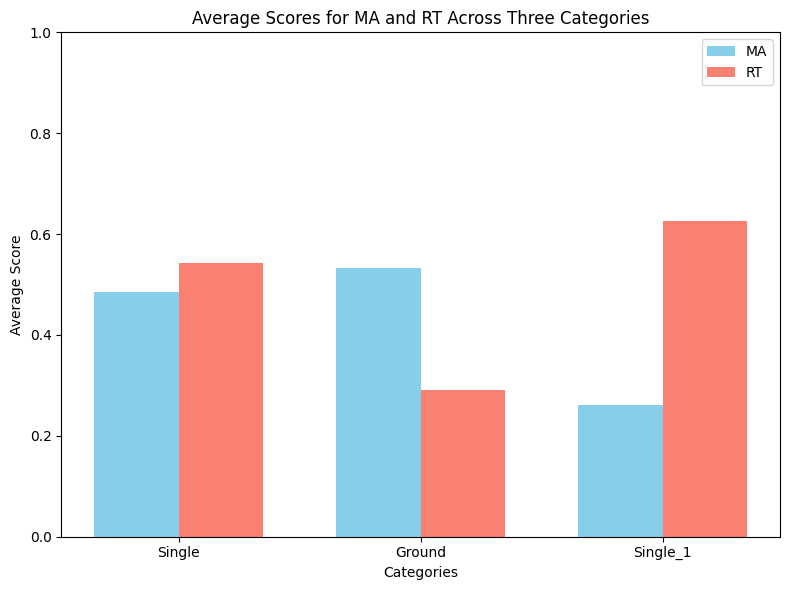

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Category labels
labels = ['Single', 'Ground', 'Single_1']

# Average scores for MA and RT for each category
MA_averages = [0.4849494949494949,0.533030303030303 , 0.2604040404040404]
RT_averages = [0.5416666666666666,0.29166666666666663 , 0.625]

x = np.arange(len(labels))
width = 0.35  # Width of each bar

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, MA_averages, width, label='MA', color='skyblue')
plt.bar(x + width/2, RT_averages, width, label='RT', color='salmon')

plt.xlabel('Categories')
plt.ylabel('Average Score')
plt.title('Average Scores for MA and RT Across Three Categories')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# EXPERIMENT WITH NEW CONVERSATIONS AND SOAP NOTES

In [ ]:
import os
import autogen
import autogen.runtime_logging
import pandas as pd
import sqlite3
import json
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
from multi_agent import subjective_agent,objective_agent,assessment_plan_agent
from general_SOAP_Note_agent import single_agent_generation,soapnoteagent
from evaluation_agent import evaluator_agent,score_generation,detail_score_generation
from refiner_agent import refiner_agent,refine_generation

Patching name='__init__', member=<function LLMLingua.__init__ at 0x000001CEBFF51440>, patched=<function function.__call__ at 0x000001CEBFF513A0>
Patching name='compress_text', member=<function LLMLingua.compress_text at 0x000001CEBFF514E0>, patched=<function function.__call__ at 0x000001CEBFF51620>


In [ ]:
from pypdf import PdfReader
import os

In [ ]:
MA_path="C:/Users/rahul/Desktop/SOAPNote/dataset/Cohort 4 Training (RT & MA) Summer 2025/MA"
RT_path="C:/Users/rahul/Desktop/SOAPNote/dataset/Cohort 4 Training (RT & MA) Summer 2025/RT"
MA_conversation_list_2=[]
RT_conversation_list_2=[]
RT_SOAP_NOTES_2=""
MA_SOAP_NOTES_2=""
session2_file_name="C:/Users/rahul/Desktop/SOAPNote/dataset/Cohort 4 Training (RT & MA) Summer 2025/MA/Session 2 Transcript_ M.A. (7-10-2025).pdf"
reader=PdfReader(session2_file_name)
transcript=""
for j in range(0,len(reader.pages)):
    page=reader.pages[j]
    text=page.extract_text()
    text=text.replace('\n','')
    transcript+=text
MA_conversation_list_2.append(transcript)
for i in os.listdir(MA_path):
    if 'pdf' in i and 'SOAP Notes' not in i:
        transcript_ma=""
        file_name=MA_path+'/'+i
        reader=PdfReader(file_name)
        for j in range(0,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            transcript_ma+=text
        MA_conversation_list_2.append(transcript_ma)
    elif 'pdf' in i and 'SOAP Notes' in i:
        file_name=MA_path+'/'+i
        reader=PdfReader(file_name)
        for j in range(0,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            MA_SOAP_NOTES_2+=text


for i in os.listdir(RT_path):
    if 'pdf' in i and 'SOAP Notes' not in i:
        transcript_ma=""
        file_name=RT_path+'/'+i
        reader=PdfReader(file_name)
        for j in range(0,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            transcript_ma+=text
        RT_conversation_list_2.append(transcript_ma)

file_name="C:/Users/rahul/Desktop/SOAPNote/dataset/Cohort 4 Training (RT & MA) Summer 2025/RT/R.T. SOAP Note (Cohor 4 2025).pdf"
reader=PdfReader(file_name)
for j in range(0,len(reader.pages)):
    page=reader.pages[j]
    text=page.extract_text()
    text=text.replace('\n','')
    RT_SOAP_NOTES_2+=text

MA_SOAP_NOTE_LIST=[MA_SOAP_NOTES_2.split('Session 2')[1].split('Session 3')[0],MA_SOAP_NOTES_2.split('Session 4')[1].split('Session 5')[0],MA_SOAP_NOTES_2.split('Session 6')[1]]
RT_SOAP_NOTE_LIST=[RT_SOAP_NOTES_2.split('Session 1')[1].split('Session 2')[0],
RT_SOAP_NOTES_2.split('Session 2')[1].split('Session 3')[0],
RT_SOAP_NOTES_2.split('Session 3')[1].split('Session 4')[0],
RT_SOAP_NOTES_2.split('Session 4')[1].split('Session 5')[0],
RT_SOAP_NOTES_2.split('Session 5')[1].split('Session 6')[0],
RT_SOAP_NOTES_2.split('Session 6')[1].split('Session 1')[0]]
RT_SOAP_NOTE_LIST=RT_SOAP_NOTE_LIST[1:]
MA_conversation_list_2_1=MA_conversation_list_2[2:]
MA_conversation_list_2_1[2]=MA_conversation_list_2_1[2]+"\n"+MA_conversation_list_2_1[3]
MA_conversation_list_2_final=MA_conversation_list_2_1[0:3]
    

In [ ]:
print(RT_SOAP_NOTE_LIST)

[": 7-10-2025 News & Facts S: 1 hour research session: Gemini/Alexa summer training. Client presented as engaged and eager to participate. O: Word finding challenges were observed.  ● Client engaged in using voice assistive technology (VAT) tools, including Alexa and Google Gemini, to gather information on topics of interest and current events ○ Texas Flooding and Biotechnology ● Client responded well to structured models and visual supports ● Client attempted prompts like “What is happening in Texas in the floods?” but required additional time to formulate questions. ●  Client omitted the wake word “Alexa” in one instance  ● Client required minimal to moderate prompting to revise prompts for clarity and specificity (e.g., “Can you provide me with local biotechnology news in Orange County?”).  ○ Original Prompt ■ Tell me about the flooding event in Texas ○ Revisions to Prompt  ■ Please summarize in three key facts with bullet points ■ Summarize each bullet point in one sentence ○ Origi

In [ ]:
MA_objective_list=[i.split('O:')[1].split("A:")[0] for i in MA_SOAP_NOTE_LIST_2[:-1]]
RT_objective_list=[i.split('O')[1].split("A ")[0] for i in RT_SOAP_NOTE_LIST_2]
MA_objective_list.append(MA_SOAP_NOTE_LIST_2[-1].split('Objective')[1].split('Assessment')[0])
objective_list=MA_objective_list+RT_objective_list
conversation_list_for_optimization=MA_conversation_list_2+RT_TRANSCRIPTS[8:13]

objective_list


['  -Discussed what participant does in various functional scenarios while utilizing Meta glasses. -Reviewed and trialed prompts with Gemini 2.5 flash on participant’s ipad and cellular devices.  -Assisted participant and caregiver with permissions and settings to enable microphone access and audio playback feature   Participant generated commands with clinician assistance:  ● Hey Gemini, what’s your favorite color? Why/how ○ Gemini response: As a LLM, I don’t have personal preferences, I’m here to provide information or assist in tasks for you ● Hey Gemini, what’s new? ● Hey Gemini, what are the updates with Israel and Iran? ● Hey Google, what is the weather like today? ● Can you provide me with a summary of the latest local news? ● Can you provide me with highlights of the latest local news? ● Can you provide me with the latest local news in three sentences? ○ Gemini thought participant said “centimeters” instead of “sentences”  ○ Gemini response: prompted user to request for “very b

In [ ]:
from sklearn.model_selection import train_test_split
training_dict=dict()
for i in range(0,len(MA_conversation_list_2_final)):
    training_dict[MA_conversation_list_2_final[i]]=MA_objective_list[i]

for i in range(0,len(RT_TRANSCRIPTS[8:13])):
    training_dict[RT_TRANSCRIPTS[8:13][i]]=RT_objective_list[i]

X=list(training_dict.keys())
y=list(training_dict.values())
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42)

In [70]:
communication_instances_test=[]
file_name='C:/Users/rahul/Desktop/SOAPNote/multi_stage_classification.pdf'
reader = PdfReader(file_name)
example=''
for i in range(0,len(reader.pages)):
    page=reader.pages[i]
    text=page.extract_text()
    text=text.replace('\n','')
    example+=text
for i in X_test:
    communication_instances_test.append(multi_class_classification(i,example))

In [71]:
communication_instances_test

['Instance #1: SUCCESSFUL - Patient M successfully set an appointment with Alexa after a second attempt. - Patient M initially had to repeat the command, but Alexa responded correctly on the second try, setting an appointment for 5:45 PM.\n\nInstance #2: SUCCESSFUL - Patient M successfully asked Alexa to tell a joke. - Patient M requested a joke, and Alexa responded with a Despicable Me joke.\n\nInstance #3: UNSUCCESSFUL - Alexa error - Patient M attempted to play a Nipsey Hussle song, but Alexa could not find it in the library. - Alexa suggested signing up for Amazon Music Unlimited, indicating a limitation in the available music library.\n\nInstance #4: UNSUCCESSFUL - Alexa error - Patient M attempted to fast forward a song, but Alexa stated it could not fast forward the stream. - This indicates a limitation in the streaming service being used.\n\nInstance #5: SUCCESSFUL - Patient M successfully adjusted the volume using Alexa. - Patient M was able to increase and decrease the volume